# Gaussian Process Latent Variable Model

In [52]:
import numpy as np
import GPy
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


In [42]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

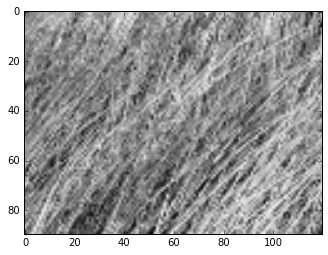

In [55]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)
sample = (sample - sample_mean)/sample_std # normalization

print(sample)

[[-1.11651213 -1.01944808 -0.23999337 ..., -0.12147499 -1.15733176
  -1.52699203]
 [-0.28189271 -0.92650059 -0.3284865  ...,  0.78656064 -0.78029405
   1.12758945]
 [ 0.39623557 -0.8335531  -0.01876054 ...,  1.19013202  0.17680168
   3.23846147]
 ..., 
 [-2.1597864   0.14239556 -0.85944528 ...,  0.3493583  -0.72228825
   1.03164073]
 [ 1.49167355 -0.36881564 -1.25766437 ...,  0.08031071  0.98888291
   0.10413635]
 [-0.54271128  1.86192413 -0.90369185 ...,  1.02197728  0.5538394
  -0.27965856]]


In [5]:
#kernel = GPy.kern.Linear(Q, ARD=True)
kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
m = GPy.models.GPLVM(sample, input_dim=Q, kernel=kernel, init='PCA')

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=10000)

In [7]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -0.73237351  |               |        
  [0 1]      |         0.79619964  |               |        
  [0 2]      |        -1.08290982  |               |        
  [0 3]      |        -1.06130005  |               |        
  [0 4]      |         0.19001370  |               |        
  [0 5]      |        -1.75484111  |               |        
  [0 6]      |         0.97875435  |               |        
  [0 7]      |         0.74545689  |               |        
  [0 8]      |        -0.28952920  |               |        
  [0 9]      |         0.09607163  |               |        
  [ 0 10]    |        -0.39301780  |               |        
  [ 0 11]    |         0.87758532  |               |        
  [ 0 12]    |        -0.25443076  |               |        
  [ 0 13]    |         0.79299235  |               |        
  [ 0 14]    |        -1.30226679  |               |        
  [ 0 15]    |         1

In [8]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.96735049  0.45760317  0.29220595 ...,  0.02630844  0.0521793
   0.06212991]
 [ 0.45760317  1.00334124  0.49417447 ...,  0.01314812  0.04367324
   0.06262525]
 [ 0.29220595  0.49417447  1.03274295 ...,  0.02322465  0.05098839
   0.07144985]
 ..., 
 [ 0.02630844  0.01314812  0.02322465 ...,  0.95358059  0.24003244
   0.07774241]
 [ 0.0521793   0.04367324  0.05098839 ...,  0.24003244  0.94399944
   0.25645183]
 [ 0.06212991  0.06262525  0.07144985 ...,  0.07774241  0.25645183
   0.93111421]]


In [9]:
def predict_new_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    R = np.random.multivariate_normal(meann,cov)
    
    return R

In [10]:
N_synt = 50
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[ -1.24396341e+00   1.43048353e-01   2.42203968e-01   3.19778151e-01
   -2.01627548e-01  -1.67996344e+00   6.37068940e-02   1.28771520e+00
   -6.55996195e-01  -3.87852835e-01  -9.71428072e-01   1.49390506e+00
   -1.52070896e+00   3.91189873e-01  -3.36300916e-01   2.64522449e-01
    5.41075912e-01   1.46054992e+00   3.13582972e-01  -4.32281469e-01]
 [  7.43497580e-01  -5.91675254e-01   1.20905578e+00  -1.01473636e+00
    1.84136412e-03  -9.79784498e-01  -2.14292581e-01   1.98009529e+00
   -3.98521501e-01  -8.43263995e-01   1.55842070e+00   9.21234413e-01
    9.13585241e-01   2.76279365e+00  -9.92205109e-01  -4.10200851e-01
   -7.21193314e-02   6.15016617e-01  -4.60334335e-01  -6.77029499e-01]
 [  1.97572501e+00   5.45786144e-01   9.79206636e-01  -4.43201699e-01
   -1.80192937e+00  -4.85326487e-01   2.46743134e+00   4.53093990e-01
   -1.96843784e+00   6.67406711e-01  -3.97397886e-01  -1.47552330e+00
    1.14895467e+00   1.58934702e+00  -9.73761788e-01   1.14368852e-02
    1.09984808e-01

In [33]:
X_synt[:,0]

array([ -1.24396341e+00,   7.43497580e-01,   1.97572501e+00,
         1.34743403e+00,   1.19206237e+00,   1.04562433e+00,
         9.44350140e-01,   5.75369735e-01,  -1.11225988e-01,
        -2.91261339e-01,  -1.01864009e-02,   1.02417073e+00,
        -1.60383600e-01,   7.25730742e-01,   2.84625431e-01,
        -4.22764790e-01,   7.10061463e-02,   6.49784683e-01,
         1.77330637e+00,  -2.70843155e-01,  -6.13794230e-01,
         1.41812589e-03,  -4.40420669e-01,   1.03919914e+00,
         7.44332882e-01,  -5.29417515e-01,   6.04189409e-01,
         1.29535837e+00,   1.72187118e+00,   9.03591239e-01,
         1.03784417e+00,   5.13308278e-02,   9.82584111e-01,
         8.73008788e-02,   1.86241362e+00,   9.34727418e-01,
         2.11761303e-01,  -3.57212916e-01,  -1.16875091e+00,
        -9.81499872e-01,  -8.23717019e-01,   5.74646254e-01,
         8.21121970e-01,  -1.56223046e-01,  -1.24422869e+00,
        -2.49611928e+00,  -3.91307982e+00,  -4.86790443e+00,
        -2.83373696e+00,

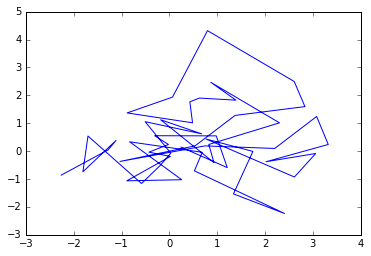

In [35]:
mp.plot(X_synt[:,2],X_synt[:,1])

In [11]:
def reconstruct_new_frame(N,D,X,Y,kern,Ky_inv,X_synt_i):
    
    R = np.zeros(D)
    
    k_y = kern.K(X,X_synt_i)
    k_yy = kern.K(X_synt_i,X_synt_i)

    meann = np.matmul(np.matmul(np.transpose(Y),Ky_inv),k_y).flatten()
    cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y)) * np.eye(D)
    
    R = np.random.multivariate_normal(meann,cov)
    print(R)
    
    return R

In [12]:
Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)

for i in range(N_synt):
    print(i)
    Y_synt[i,:] = reconstruct_new_frame(N,D,X,sample,kernel2,Ky_inv,X_synt[i,:].reshape(1,Q))
    
print(Y_synt)
print(np.size(Y_synt))

0
[-1.58114671 -0.91620841 -0.5484054  ...,  0.43711909  1.91781942
 -0.08903022]
1
[ 0.3769617  -1.7018819  -1.48826833 ...,  0.77278057  0.74570527
 -0.71465481]
2
[-0.3304641   1.64250538  0.33945503 ...,  0.84492412 -0.0517956
 -0.79054588]
3
[-2.0299063  -0.98505846  0.15739852 ..., -1.09699382  0.0936081   1.1954115 ]
4
[ 0.54702138  1.05307759 -0.59237358 ...,  1.28410874  0.53816272
  0.96936055]
5
[-1.00837762  0.46501876 -0.47543621 ...,  0.07588851 -0.06685109
 -0.75353097]
6
[ 0.17009903  0.7264043  -0.33888232 ..., -1.26768412  0.27559471
 -0.37174112]
7
[ 0.42927412 -0.92195566 -2.21637192 ...,  0.51326755 -0.12736601
 -0.15269648]
8
[ 0.52027551  0.07114709  0.37456403 ...,  1.00266557 -1.29216969
  0.21175887]
9
[-0.51167694 -1.41319203  0.78166792 ..., -0.67010746  1.06336488
 -1.31735169]
10
[ 0.18797952 -0.3994532  -0.83137808 ..., -0.13233826 -1.04404329
  0.59665335]
11
[ 1.55866583  0.72254288 -1.33464264 ...,  0.29679699 -0.59001609
  1.63052101]
12
[ 0.47840004 

In [ ]:
np.random.multivariate_normal(meann,cov)

In [ ]:
R = np.random.multivariate_normal(meann,cov)
print(R)

In [ ]:
R

In [ ]:
Y = sample_std * R + sample_mean

In [ ]:
Y

In [ ]:
show_frame(R)

In [ ]:
show_frame(Y)

In [13]:
Y_synt_demorm = sample_std * Y_synt + sample_mean

In [14]:
Y_synt_demorm[0,:].reshape((w,h)).astype(int)

array([[107, 123, 123, ..., 126, 114, 108],
       [143, 126, 101, ..., 118, 125, 112],
       [152, 127, 123, ..., 125, 104,  82],
       ..., 
       [150, 119, 166, ..., 114, 127, 141],
       [ 73,  74, 107, ...,  69, 109,  97],
       [ 78, 103, 128, ..., 125, 173, 109]])

In [ ]:
Y_synt = np.zeros((N_synt,D))

for i in range(D):
    Y_synt[:,i] = np.sqrt(cov[i,i])*np.random.randn(N_synt) + meann[i]

print(Y_synt)

In [ ]:
# new version:

Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)

for i in range(N_synt):
    
    X_synt_i = X_synt[i,:].reshape(1,Q)
    
    k_y = kernel2.K(X,X_synt_i)
    k_yy = kernel2.K(X_synt_i,X_synt_i)

    meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
    cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))
    
    Y_synt[i,:] = np.sqrt(cov)*np.random.randn(D) + meann[i]

print(Y_synt)

In [11]:
# new new version:

Y_synt = np.zeros((N_synt,D))

kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)


    
k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt)
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[ 0.39666814  1.3576599   0.32893968 ...,  1.09968315 -0.20559595
   0.77606383]
 [ 0.83967644 -1.96670092  0.13777695 ..., -1.59413072  0.44613351
   0.12122482]
 [ 0.42406499  2.60890949 -1.8709914  ...,  0.01669548  0.28651629
  -2.03149535]
 ..., 
 [-1.39154971 -0.35485455 -0.39255418 ...,  0.09704634 -1.64409169
   1.07110299]
 [ 0.03960313 -0.09472513 -0.5774366  ...,  0.7506244   0.1253672
   0.57676923]
 [ 1.03733148  3.30193354  0.27955052 ..., -0.66205254 -1.09726817
  -0.11575966]]


In [114]:
kernel2 = GPy.kern.RBF(Q,ARD=True)
Ky = kernel2.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample)

k_y = kernel2.K(X,X_synt)
k_yy = kernel2.K(X_synt,X_synt) + np.eye(N_synt)*1
meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))

In [115]:
cov

array([[  1.99999995e+00,   2.45551596e-03,   1.22773430e-04, ...,
         -3.71161373e-12,   2.03715128e-07,  -4.20122882e-10],
       [  2.45551596e-03,   1.99999593e+00,   1.11138122e-03, ...,
         -1.14735782e-11,   1.28512108e-09,  -1.17623292e-10],
       [  1.22773430e-04,   1.11138122e-03,   1.99999979e+00, ...,
          1.28659498e-12,   6.09416337e-09,  -1.52301684e-11],
       ..., 
       [ -3.71161373e-12,  -1.14735782e-11,   1.28659498e-12, ...,
          1.99999998e+00,   9.90876432e-06,   6.17913198e-06],
       [  2.03715128e-07,   1.28512108e-09,   6.09416337e-09, ...,
          9.90876432e-06,   1.99999912e+00,   2.39422947e-03],
       [ -4.20122882e-10,  -1.17623292e-10,  -1.52301684e-11, ...,
          6.17913198e-06,   2.39422947e-03,   1.99999930e+00]])

In [81]:
np.sqrt(cov)

 C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning:invalid value encountered in sqrt


array([[  1.41421355e+00,   4.95531630e-02,   1.10803172e-02, ...,
                     nan,   4.51348123e-04,              nan],
       [  4.95531630e-02,   1.41421212e+00,   3.33373848e-02, ...,
                     nan,   3.58485854e-05,              nan],
       [  1.10803172e-02,   3.33373848e-02,   1.41421349e+00, ...,
          1.13428170e-06,   7.80651226e-05,              nan],
       ..., 
       [             nan,              nan,   1.13428170e-06, ...,
          1.41421356e+00,   3.14781898e-03,   2.48578599e-03],
       [  4.51348123e-04,   3.58485854e-05,   7.80651226e-05, ...,
          3.14781898e-03,   1.41421325e+00,   4.89308642e-02],
       [             nan,              nan,              nan, ...,
          2.48578599e-03,   4.89308642e-02,   1.41421331e+00]])

In [12]:
Y_synt_demorm = sample_std * Y_synt + sample_mean

In [13]:
np.size(Y_synt)

540000

In [14]:
120*90*500

5400000

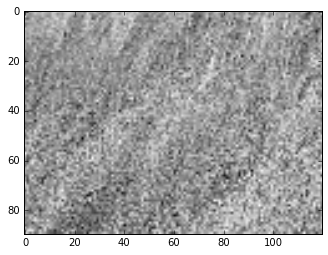

In [15]:
show_frame(Y_synt_demorm[1,:])

In [16]:
Y_synt_demorm[:,:].max()

252.60247607126797

In [17]:
cap = cv2.VideoCapture(0)
#fourcc = cv2.VideoWriter_fourcc(*'DIB ')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_demorm[i,:].reshape((h,w)).astype(int)
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame/3
    img[:,:,1] = frame/3
    img[:,:,2] = frame/3
    #colorFrame = np.zeros((w,h,3), np.uint8)
    #colorFrame = cv2.COLOR_GRAY2RGB(frame)
    #new_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    #colorFrame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    out.write(img)
    print(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
[[[48 48 48]
  [57 57 57]
  [47 47 47]
  ..., 
  [45 45 45]
  [36 36 36]
  [44 44 44]]

 [[32 32 32]
  [36 36 36]
  [45 45 45]
  ..., 
  [42 42 42]
  [45 45 45]
  [44 44 44]]

 [[38 38 38]
  [36 36 36]
  [40 40 40]
  ..., 
  [34 34 34]
  [36 36 36]
  [37 37 37]]

 ..., 
 [[44 44 44]
  [36 36 36]
  [37 37 37]
  ..., 
  [46 46 46]
  [27 27 27]
  [29 29 29]]

 [[31 31 31]
  [44 44 44]
  [41 41 41]
  ..., 
  [34 34 34]
  [22 22 22]
  [51 51 51]]

 [[68 68 68]
  [44 44 44]
  [41 41 41]
  ..., 
  [48 48 48]
  [33 33 33]
  [45 45 45]]]
1
[[[51 51 51]
  [33 33 33]
  [46 46 46]
  ..., 
  [37 37 37]
  [42 42 42]
  [46 46 46]]

 [[38 38 38]
  [43 43 43]
  [37 37 37]
  ..., 
  [38 38 38]
  [34 34 34]
  [51 51 51]]

 [[53 53 53]
  [38 38 38]
  [40 40 40]
  ..., 
  [40 40 40]
  [45 45 45]
  [30 30 30]]

 ..., 
 [[46 46 46]
  [38 38 38]
  [47 47 47]
  ..., 
  [44 44 44]
  [42 42 42]
  [52 52 52]]

 [[29 29 29]
  [57 57 57]
  [62 62 62]
  ..., 
  [46 46 46]
  [37 37 37]
  [36 36 36]]

 [[58 58 58]
 